# Multimodal Hate Speech Detection

## Install dependencies and create environment

- Install [MMF Framework](https://mmf.sh/docs)
- https://mmf.sh/docs/tutorials/checkpointing
- https://github.com/facebookresearch/mmf
- https://github.com/apsdehal/hm_example_mmf
- https://www.drivendata.co/blog/hateful-memes-benchmark/
- https://github.com/facebookresearch/mmf/tree/main/projects/hateful_memes


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --pre mmf

     |████████████████████████████████| 404 kB 7.4 MB/s 
     |████████████████████████████████| 450 kB 60.5 MB/s 
     |████████████████████████████████| 131 kB 74.8 MB/s 
     |████████████████████████████████| 869 kB 42.8 MB/s 
     |████████████████████████████████| 447 kB 52.5 MB/s 
     |████████████████████████████████| 1.5 MB 63.8 MB/s 
     |████████████████████████████████| 57 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 26.0 MB/s 
     |████████████████████████████████| 752.0 MB 9.9 kB/s 
     |████████████████████████████████| 73 kB 2.1 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 1.2 MB 61.0 MB/s 
     |████████████████████████████████| 131 kB 61.8 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 
     |████████████████████████████████| 8.4 MB 61.3 MB/s 
     |████████████

In [3]:
!git clone https://github.com/amankhullar/mmf.git

Cloning into 'mmf'...
remote: Enumerating objects: 23148, done.
remote: Counting objects: 100% (3091/3091), done.
remote: Compressing objects: 100% (822/822), done.
remote: Total 23148 (delta 2237), reused 2813 (delta 2042), pack-reused 20057
Receiving objects: 100% (23148/23148), 16.52 MiB | 20.68 MiB/s, done.
Resolving deltas: 100% (15053/15053), done.


In [4]:
!cp mmf/mmf_cli/hm_convert.py /usr/local/lib/python3.7/dist-packages/mmf_cli/

### Configure dataset

In [5]:
!mmf_convert_hm --zip_file=drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes.zip

Data folder is /root/.cache/torch/mmf/data
Zip path is drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes.zip
Copying drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes.zip
Unzipping drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes.zip
Extracting the zip can take time. Sit back and relax.
Moving train.jsonl
Moving dev_seen.jsonl
Moving test_seen.jsonl
Moving dev_unseen.jsonl
Moving test_unseen.jsonl
Moving img


In [6]:
!cp /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev_unseen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev.jsonl
!cp /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test_unseen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test.jsonl

## Register the Meme dataset inside the library

In [7]:
# Copyright (c) Facebook, Inc. and its affiliates.

import os
import warnings

from mmf.common.registry import registry
from mmf.datasets.builders.hateful_memes.dataset import (
    HatefulMemesFeaturesDataset,
    HatefulMemesImageDataset,
)
from mmf.datasets.mmf_dataset_builder import MMFDatasetBuilder
from mmf.utils.configuration import get_mmf_env
from mmf.utils.file_io import PathManager
from mmf.utils.general import get_absolute_path


@registry.register_builder("hateful_memes")
class HatefulMemesBuilder(MMFDatasetBuilder):
    def __init__(
        self,
        dataset_name="hateful_memes",
        dataset_class=HatefulMemesImageDataset,
        *args,
        **kwargs
    ):
        super().__init__(dataset_name, dataset_class, *args, **kwargs)
        self.dataset_class = HatefulMemesImageDataset

    @classmethod
    def config_path(self):
        return "configs/datasets/hateful_memes/defaults.yaml"

    def load(self, config, dataset_type, *args, **kwargs):
        config = config

        if config.use_features:
            self.dataset_class = HatefulMemesFeaturesDataset

        self.dataset = super().load(config, dataset_type, *args, **kwargs)

        return self.dataset

    def build(self, config, *args, **kwargs):
        # First, check whether manual downloads have been performed


        # NOTE: made the change here for the path update
        # data_dir = get_mmf_env(key="data_dir")
        data_dir = os.path.join(os.getcwd(), '/root/.cache/torch/mmf/data/datasets/hateful_memes')

        # test_path = get_absolute_path(
        #     os.path.join(
        #         data_dir,
        #         "datasets",
        #         self.dataset_name,
        #         "defaults",
        #         "annotations",
        #         "train.jsonl",
        #     )
        # )
        # test_path = get_absolute_path(os.path.join(data_dir, "train.jsonl"))

        test_path = "/root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/train.jsonl"
        print(test_path)

        # NOTE: This doesn't check for files, but that is a fine assumption for now
        assert PathManager.exists(test_path), (
            "Hateful Memes Dataset doesn't do automatic downloads; please "
            + "follow instructions at https://fb.me/hm_prerequisites"
        )
        super().build(config, *args, **kwargs)

    def update_registry_for_model(self, config):
        if hasattr(self.dataset, "text_processor") and hasattr(
            self.dataset.text_processor, "get_vocab_size"
        ):
            registry.register(
                self.dataset_name + "_text_vocab_size",
                self.dataset.text_processor.get_vocab_size(),
            )
        registry.register(self.dataset_name + "_num_final_outputs", 2)

In [ ]:
# Earlier approach
# !cp drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/train.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/train.jsonl
# !cp drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/dev_seen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev_seen.jsonl
# !cp drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/test_seen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test_seen.jsonl
# !cp -r drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/img /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images

In [ ]:
# !cp drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/dev_seen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev.jsonl
# !cp drive/MyDrive/GaTech/HateSpeechDetection/hateful_memes/test_seen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test.jsonl

/root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/train.jsonl
[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz to /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz ]


[ Starting checksum for extras.tar.gz]
[ Checksum successful for extras.tar.gz]
Unpacking extras.tar.gz


/root/.cache/torch/mmf/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:41<00:00, 9718.46it/s]


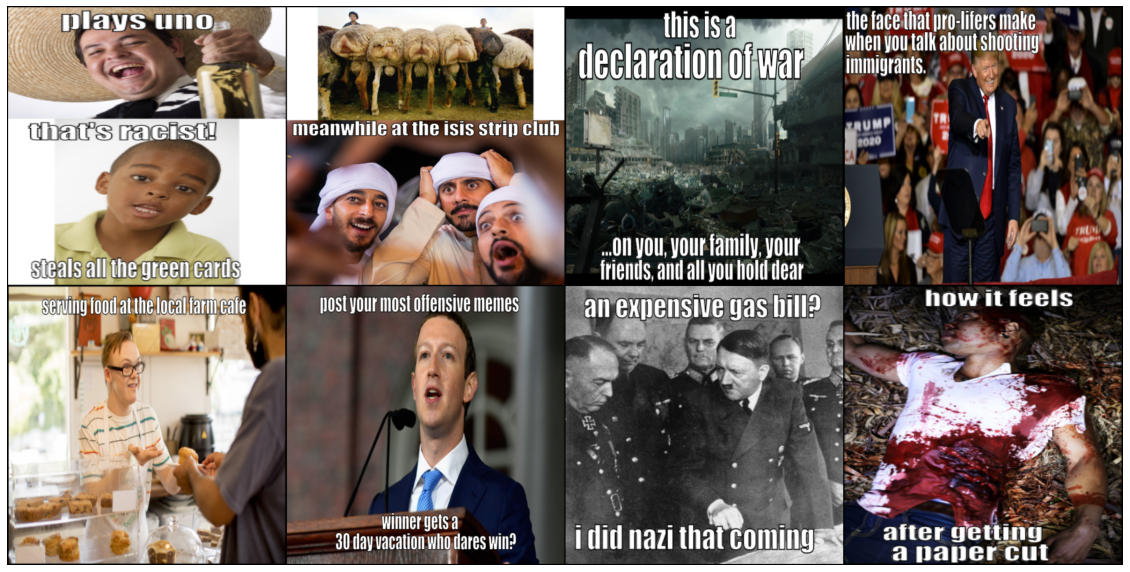

In [8]:
from mmf.common.registry import registry
from mmf.models.mmbt import MMBT
from mmf.utils.build import build_dataset
from mmf.utils.env import setup_imports

setup_imports()
dataset = build_dataset("hateful_memes")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)
dataset.visualize(num_samples=8, size=(512, 512), nrow=4)

###Test a pretrained model
- Using clues from [this](https://colab.research.google.com/github/facebookresearch/mmf/blob/notebooks/notebooks/mmf_hm_example.ipynb#scrollTo=ZKzyiRYuUMYj) notebook

In [9]:
import matplotlib.pyplot as plt
import requests

from PIL import Image

from mmf.models.mmbt import MMBT
from mmf.models.visual_bert import VisualBERTBase

model = MMBT.from_pretrained("mmbt.hateful_memes.images")
# model_visbert = VisualBERTBase.from_pretrained("visual_bert.hateful_memes.images")

[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/mmbt/mmbt.finetuned.hateful_memes_images.tar.gz to /root/.cache/torch/mmf/data/models/mmbt.hateful_memes.images/mmbt.finetuned.hateful_memes_images.tar.gz ]


[ Starting checksum for mmbt.finetuned.hateful_memes_images.tar.gz]
[ Checksum successful for mmbt.finetuned.hateful_memes_images.tar.gz]
Unpacking mmbt.finetuned.hateful_memes_images.tar.gz


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
from mmf.common.registry import registry

model_cls = registry.get_model_class("visual_bert")
model_visbert = model_cls.from_pretrained("visual_bert.finetuned.hateful_memes.from_coco")

[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/visual_bert/visual_bert.finetuned.hateful_memes_from_coco.tar.gz to /root/.cache/torch/mmf/data/models/visual_bert.finetuned.hateful_memes.from_coco/visual_bert.finetuned.hateful_memes_from_coco.tar.gz ]


[ Starting checksum for visual_bert.finetuned.hateful_memes_from_coco.tar.gz]
[ Checksum successful for visual_bert.finetuned.hateful_memes_from_coco.tar.gz]
Unpacking visual_bert.finetuned.hateful_memes_from_coco.tar.gz


/usr/local/lib/python3.7/dist-packages/omegaconf/dictconfig.py:252: UserWarning: Keys with dot (model.bert) are deprecated and will have different semantic meaning the next major version of OmegaConf (2.1)
See the compact keys issue for more details: https://github.com/omry/omegaconf/issues/152
You can disable this warning by setting the environment variable OC_DISABLE_DOT_ACCESS_WARNING=1
  warnings.warn(message=msg, category=UserWarning)


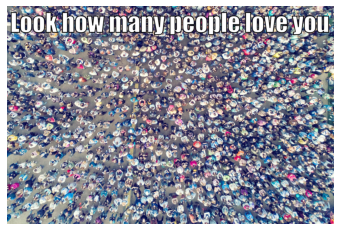

Hateful as per the model? No
Model's confidence: 95.917%


In [ ]:
image_url = "https://i.imgur.com/tEcsk5q.jpg" #@param {type:"string"}
text = "" #@param {type: "string"}
output = model.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

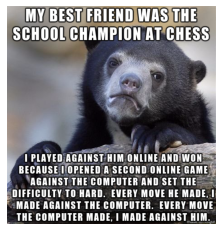

Hateful as per the model? Yes
Model's confidence: 98.634%


In [ ]:
image_url = "https://i.imgur.com/Pu3I8av.png" #@param {type:"string"}
text = "" #@param {type: "string"}
output = model.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

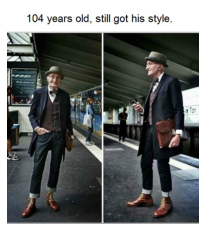

Hateful as per the model? Yes
Model's confidence: 59.894%


In [ ]:
image_url = "https://i.imgur.com/ud7L1SN.jpeg" #@param {type:"string"}
text = "" #@param {type: "string"}
output = model.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

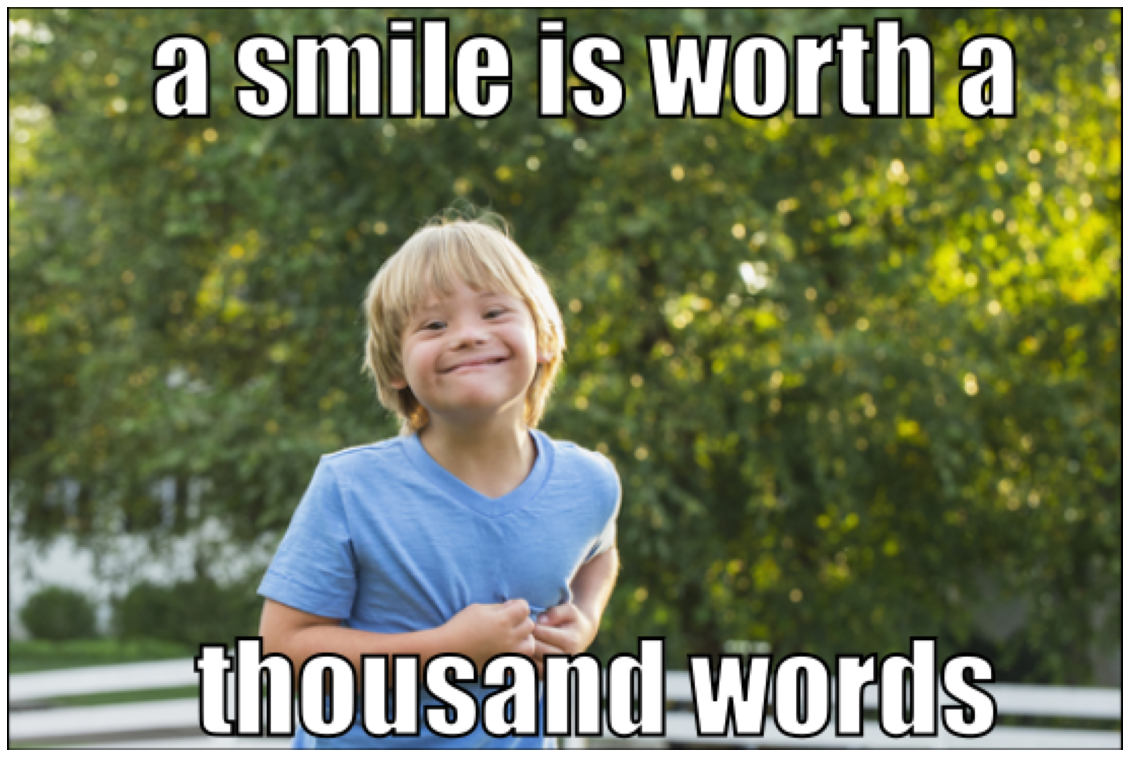

Hateful as per the model? No
Model's confidence: 99.996%


In [10]:
image_url = "https://i.ibb.co/hDH5SVq/01276.png" #@param {type:"string"}
text = "hate the way you smile" #@param {type: "string"}
output = model.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

### BERT unimodal

In [ ]:
!mmf_run config=projects/hateful_memes/configs/unimodal/bert.yaml \
  model=unimodal_text \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/unimodal/bert.yaml', 'model=unimodal_text', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/unimodal/bert.yaml
Overriding option model to unimodal_text
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 2298491
Logging to: ./save/logs/train_2021-11-13T03:07:02.log
100% 125/125 [00:26<00:00,  4.69it/s]


In [ ]:
!ls save

best.ckpt    current.ckpt  models     unimodal_text_final.pth
config.yaml  logs	   train.log


### MMBT

In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
  model=mmbt \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 39064676
Logging to: ./save/logs/train_2021-12-07T03:53:39.log
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:01<00:00, 183MB/s]
100% 125/125 [00:26<00:00,  4.78it/s]


### MMBT modal embeddings without Positional tokens

In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
  model=mmbt \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 27998535
Logging to: ./save/logs/train_2021-12-05T22:37:27.log
100% 125/125 [00:25<00:00,  4.87it/s]


### Trying different loss functions and regularization

---



In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
  model=mmbt \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 23848137
Logging to: ./save/logs/train_2021-12-06T20:31:23.log
100% 125/125 [00:25<00:00,  4.88it/s]


### Image and text weighting

In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
  model=mmbt \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 58246784
Logging to: ./save/logs/train_2021-12-06T21:35:58.log
100% 125/125 [00:26<00:00,  4.74it/s]


### Image and text dimensionality reduction

In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
  model=mmbt \
  dataset=hateful_memes \
  training.log_interval=50 \
  training.max_updates=3000 \
  training.batch_size=16 \
  training.evaluation_interval=500

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'training.log_interval=50', 'training.max_updates=3000', 'training.batch_size=16', 'training.evaluation_interval=500'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option training.log_interval to 50
Overriding option training.max_updates to 3000
Overriding option training.batch_size to 16
Overriding option training.evaluation_interval to 500
Using seed 48202998
Logging to: ./save/logs/train_2021-12-06T22:58:48.log
100% 125/125 [00:26<00:00,  4.81it/s]


In [ ]:
!cp save/mmbt_final.pth drive/MyDrive/GaTech/HateSpeechDetection/mmbt_final_15_11_2021.pth

In [ ]:
!cp save/unimodal_text_final.pth drive/MyDrive/GaTech/HateSpeechDetection/

## Model Evaluation



In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
    model=mmbt\
    dataset=hateful_memes \
    run_type=val \
    checkpoint.resume_file=save/mmbt_final.pth \
    checkpoint.resume_pretrained=False

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'run_type=val', 'checkpoint.resume_file=save/mmbt_final.pth', 'checkpoint.resume_pretrained=False'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_file to save/mmbt_final.pth
Overriding option checkpoint.resume_pretrained to False
Using seed 49414033
Logging to: ./save/logs/train_2021-12-06T23:58:49.log
17it [00:08,  1.93it/s]


### Unimodal BERT

In [ ]:
!mmf_run config=projects/hateful_memes/configs/unimodal/bert.yaml \
    model=unimodal_text\
    dataset=hateful_memes \
    run_type=val \
    checkpoint.resume_file=save/unimodal_text_final.pth \
    checkpoint.resume_pretrained=False

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/unimodal/bert.yaml', 'model=unimodal_text', 'dataset=hateful_memes', 'run_type=val', 'checkpoint.resume_file=save/unimodal_text_final.pth', 'checkpoint.resume_pretrained=False'])
Overriding option config to projects/hateful_memes/configs/unimodal/bert.yaml
Overriding option model to unimodal_text
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_file to save/unimodal_text_final.pth
Overriding option checkpoint.resume_pretrained to False
Using seed 45328841
Logging to: ./save/logs/train_2021-11-13T03:48:45.log
5it [00:12,  2.50s/it]


### MMBT

In [ ]:
!mmf_run config=projects/hateful_memes/configs/mmbt/defaults.yaml \
    model=mmbt\
    dataset=hateful_memes \
    run_type=val \
    checkpoint.resume_file=save/mmbt_final.pth \
    checkpoint.resume_pretrained=False

> Log Results on Validation set

val/total_loss: 1.0611, val/hateful_memes/cross_entropy: 1.0611, val/hateful_memes/accuracy: 0.5780, val/hateful_memes/binary_f1: 0.4023, val/hateful_memes/roc_auc: 0.6748

## Test Set

In [ ]:
!mmf_predict config=projects/hateful_memes/configs/unimodal/bert.yaml \
    model=unimodal_text \
    dataset=hateful_memes \
    run_type=test \
    checkpoint.resume_file=save/unimodal_text_final.pth

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/unimodal/bert.yaml', 'model=unimodal_text', 'dataset=hateful_memes', 'run_type=test', 'checkpoint.resume_file=save/unimodal_text_final.pth', 'evaluation.predict=true'])
Overriding option config to projects/hateful_memes/configs/unimodal/bert.yaml
Overriding option model to unimodal_text
Overriding option datasets to hateful_memes
Overriding option run_type to test
Overriding option checkpoint.resume_file to save/unimodal_text_final.pth
Overriding option evaluation.predict to true
Using seed 27037815
Logging to: ./save/logs/train_2021-11-13T04:09:27.log
100% 16/16 [00:26<00:00,  1.67s/it]


In [ ]:
# !mmf_predict config=projects/hateful_memes/configs/mmbt/defaults.yaml model=mmbt \ 
#      dataset=hateful_memes \
#      run_type=test \ 
#      checkpoint.resume_zoo=mmbt.hateful_memes.images \
#     training.batch_size=16

!mmf_predict config=projects/hateful_memes/configs/mmbt/defaults.yaml \
    model=mmbt \
    dataset=hateful_memes \
    run_type=test \
    checkpoint.resume_file=save/mmbt_final.pth

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'run_type=test', 'checkpoint.resume_file=save/mmbt_final.pth', 'evaluation.predict=true'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to test
Overriding option checkpoint.resume_file to save/mmbt_final.pth
Overriding option evaluation.predict to true
Using seed 11447592
Logging to: ./save/logs/train_2021-12-07T05:37:11.log
100% 63/63 [00:24<00:00,  2.54it/s]


In [ ]:
!mmf_predict config=projects/hateful_memes/configs/mmbt/defaults.yaml \
    model=mmbt \
    dataset=hateful_memes \
    run_type=test \
    checkpoint.resume_zoo=mmbt.hateful_memes.images

Namespace(config_override=None, local_rank=None, opts=['config=projects/hateful_memes/configs/mmbt/defaults.yaml', 'model=mmbt', 'dataset=hateful_memes', 'run_type=test', 'checkpoint.resume_zoo=mmbt.hateful_memes.images', 'evaluation.predict=true'])
Overriding option config to projects/hateful_memes/configs/mmbt/defaults.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to test
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.images
Overriding option evaluation.predict to true
Using seed 41226520
Logging to: ./save/logs/train_2021-12-07T04:58:41.log
100% 63/63 [00:25<00:00,  2.51it/s]


In [ ]:
!cp /content/save/mmbt_final.pth drive/MyDrive/GaTech/HateSpeechDetection/

In [ ]:
!cp -r save drive/MyDrive/GaTech/HateSpeechDetection/save_mmbt_non_pos_tokens

### Make the loss and accuracy plots

In [ ]:
!ls

drive  mmf  sample_data  save


In [ ]:
!cp mmf/mmf/configs/models/mmbt/defaults.yaml /usr/local/lib/python3.7/dist-packages/mmf/configs/models/mmbt
# !ls /usr/local/lib/python3.7/dist-packages/mmf/configs/models/mmbt